In [ ]:
'''
Download the simple dataset (LibriSpeech)
'''
!wget https://www.openslr.org/resources/12/train-clean-100.tar.gz
!tar xf train-clean-100.tar.gz

--2021-06-16 15:14:55--  https://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘train-clean-100.tar.gz’

train-clean-100.tar 100%[===================>]   5.95G  11.3MB/s    in 9m 47s  

2021-06-16 15:24:43 (10.4 MB/s) - ‘train-clean-100.tar.gz’ saved [6387309499/6387309499]



In [ ]:
import math
from IPython.display import Audio
import soundfile as sf
import glob
import numpy as np
import matplotlib.pyplot as plt
Audio('/content/LibriSpeech/train-clean-100/103/1241/103-1241-0000.flac')

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import numpy as np

In [ ]:
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import soundfile as sf

In [ ]:
import os
'''
apply frame size and stide according to the paper
'''

sample_frequency = 16000 # 16kHz (LibriSpeech)
frame_size = 0.200       # 200ms
frame_stride = 0.01      # 10ms

frame_length = int(round(frame_size * sample_frequency))
frame_step = int(round(frame_stride * sample_frequency))

batch_size = 128
dirname = '/content/LibriSpeech/train-clean-100'

In [ ]:
'''
Limit the dataset to 100 speaker and for each 10
utterances. From each utterance create 10 frames
Otherwise its takes way to long to train
'''

max_speakers=100
max_utterances=10
max_num_frames = 10

In [ ]:
'''
loading the data into the RAM
'''
X=[]
y=[]
for speaker_id, speaker in enumerate(os.listdir(dirname)):
    if (speaker_id == max_speakers):
      break
    speaker_path = os.path.join(dirname, speaker)
    speaker_chapters = os.listdir(speaker_path)

    for chapter in speaker_chapters:
        chapter_path = os.path.join(speaker_path, chapter)

        chapter_utterances = os.listdir(chapter_path)

        for utterance_id, utterance in enumerate(chapter_utterances):
            if (utterance_id == max_utterances):
              break
            utterance_path = os.path.join(chapter_path, utterance)

            if (not utterance.endswith('.txt')):              
              signal, _ = sf.read(utterance_path)
              signal_length = len(signal)
              num_frames = int(np.floor((signal_length - frame_length) / frame_step))
              num_frames = min(num_frames, max_num_frames)
              
              frames = np.arange(0, num_frames * frame_step, frame_step)

              for frame in frames:
                  X.append([utterance_path, frame])
                  y.append(speaker_id)

In [ ]:
'''
Creating dataloader
'''
class LibrispeechGenerator(Sequence) :
  
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        nb_batches = len(self.y) / float(self.batch_size)
        return np.ceil(nb_batches).astype(np.int)
    
    def __getitem__(self, batch_id):
        batch_len = len(self.X[batch_id*self.batch_size:(batch_id+1)*self.batch_size])

        X_batch = np.zeros((batch_len, frame_length, 1))
        y_batch = np.zeros(batch_len)

        for i in range(batch_len):
            id = batch_id * batch_len + i

            path, frame = self.X[id]
            signal, fs = sf.read(path)

            X_batch[i, :, 0] = signal[frame:frame+frame_length]
            y_batch[i] = self.y[id]

        return X_batch, y_batch

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [ ]:
train_gen = LibrispeechGenerator(X_train, y_train, batch_size)
val_gen = LibrispeechGenerator(X_val, y_val, batch_size)

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization, LeakyReLU, Flatten, LayerNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

Creating a Baseline described in Paper of SincNet https://github.com/mravanelli/SincNet

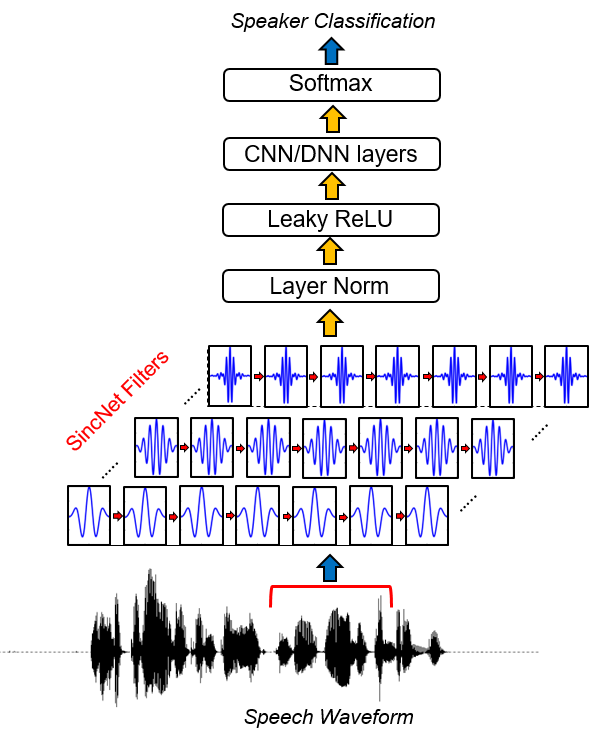

In [ ]:
def create_net(enable_sincconv=True):
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=251, input_shape=(frame_length, 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv1D(filters=60, kernel_size=5))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv1D(filters=60, kernel_size=5))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(LayerNormalization())

    model.add(Dense(1024))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(512))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(256))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(max_speakers, activation='softmax'))

    return model

net_model = create_net()

In [ ]:
net_model.compile(optimizer=RMSprop(lr=0.001, rho = 0.95),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

history_net = net_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=20)    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
142/142 [==============================] - 91s 619ms/step - loss: 3.5234 - accuracy: 0.1601 - val_loss: 4.5895 - val_accuracy: 0.1854
Epoch 2/20
142/142 [==============================] - 88s 621ms/step - loss: 2.1944 - accuracy: 0.4017 - val_loss: 4.5478 - val_accuracy: 0.1856
Epoch 3/20
142/142 [==============================] - 87s 614ms/step - loss: 1.4931 - accuracy: 0.5689 - val_loss: 3.3202 - val_accuracy: 0.2989
Epoch 4/20
142/142 [==============================] - 87s 609ms/step - loss: 1.0788 - accuracy: 0.6831 - val_loss: 3.2615 - val_accuracy: 0.3869
Epoch 5/20
142/142 [==============================] - 86s 609ms/step - loss: 0.7804 - accuracy: 0.7764 - val_loss: 1.5205 - val_accuracy: 0.5447
Epoch 6/20
142/142 [==============================] - 88s 619ms/step - loss: 0.5762 - accuracy: 0.8350 - val_loss: 2.3332 - val_accuracy: 0.4392
Epoch 7/20
142/142 [==============================] - 86s 605ms/step - loss: 0.4507 - accuracy: 0.8681 - val_loss: 2.5256 - val_ac

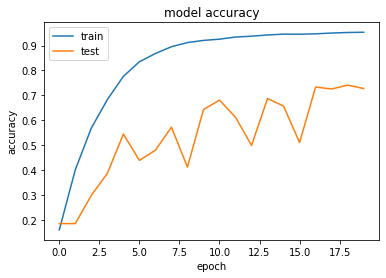

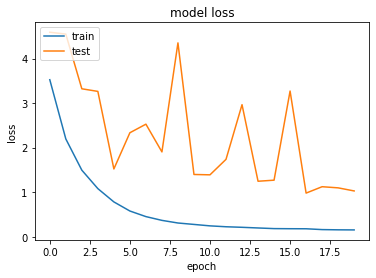

In [ ]:
# summarize history for accuracy
plt.plot(history_net.history['accuracy'])
plt.plot(history_net.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_net.history['loss'])
plt.plot(history_net.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()